In [35]:
import numpy as np
import PEsolver as pe
import xsection as xs
import scipy.integrate as sp_int
from flatstar import draw
import stellar_spectra as ss
import constants as const
import matplotlib.pyplot as plt

In [301]:
# constants
c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8


class Torus:
    def __init__(self, species, stellar_spectrum, Ms, Rs, ap, T, Rtorus, orb_el=(0, 0, 0, 1), tau=0, nH=0, calculate_abundances=True):
        self.species = species  # dictionary of species with abundances relative to hydrogen
        self.species_ion_abundances = {}  # dictionary of ion abundances to be filled in
        self.stellar_spectrum = stellar_spectrum
        self.Ms = Ms
        self.Rs = Rs
        self.ap = ap
        self.T = T
        self.Rtorus = Rtorus
        self.D = self.Rtorus[1] - self.Rtorus[0]
        self.orb_el = orb_el

        # on initialization, we calculate the hydrogen state abundances. In order to do this, we need either an number density of hydrogen or a optical depth
        gamma = pe.get_phion_rates('h', self.stellar_spectrum)[0]
        rr_rate = pe.get_rr_rates('h', T)[0]
        if tau:
            nH = pe.get_nH(tau, gamma, rr_rate, self.D)
            self.tau = tau
            self.nH = nH
        elif nH:
            tau = pe.get_tau_phot(nH, gamma, rr_rate, self.D)
            self.nH = nH
            self.tau = tau

        if calculate_abundances:
            self.calculate_ion_abundances_all_species()
            self.mu = self.get_mu()
        else:
            self.calculate_ion_abundances('h')

    # assume material rotates at keplerian velocity
    def omega_k(self, r):
        return np.sqrt(G * self.Ms / r**3)
    
    # calculate mmw
    def get_mu(self):
        rho = sum(pe.Aelem_lc[k]*self.species[k] for k in self.species)
        n = sum(self.species[Z] * (1 + sum(j * self.species_ion_abundances[Z][j] for j in range(len(self.species_ion_abundances[Z])))) for Z in self.species) 
        return rho / n 

    # assume height of the disc is the scale height of the planet
    def get_H(self):
        cs = np.sqrt(k_b * self.T / (self.mu * mp))
        disk_mid = (self.Rtorus[0] + self.Rtorus[1]) / 2
        H = np.sqrt(2 * cs**2 * disk_mid**3 / (G * self.Ms))
        return H

    def calculate_ion_abundances(self, single_species):

        if single_species in self.species_ion_abundances:
            return self.species_ion_abundances[single_species]
        elif single_species == 'h':
            h_species_solver = pe.HPhESolver(self.stellar_spectrum, self.nH)
            h_abundances = h_species_solver.calculate_abundances(self.T)
            self.species_ion_abundances['h'] = h_abundances
            return h_abundances
        elif single_species == 'he':
            he_species_solver = pe.HePhESolver(self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][0], self.nH * self.species_ion_abundances['h'][1])
            he_abundances = he_species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = he_abundances
            return he_abundances
        else:
            species_solver = pe.PhESolver(single_species, self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][1])
            ion_abundances = species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = ion_abundances
            return ion_abundances

    def calculate_ion_abundances_all_species(self):

        for sp in self.species:
            ion_abundances = self.calculate_ion_abundances(sp)
            self.species_ion_abundances[sp] = ion_abundances

    def calculate_column_density(self, species_state):
        if species_state == 'he_triplet':
            ncol = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * self.D
            return ncol
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            ncol = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * self.D
            return ncol
        else:
            print("the ionic abundances for this species has not been calculated yet")

    def calculate_tau_species(self, species_state, nlines=10):
        if species_state == 'he_triplet':
            tau = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * xs.He_triplet_xsection_atlc(self.T) * self.D
            return tau
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            species_xsection = xs.xsection(species_state, species)
            xsec, wvl = species_xsection.topN_xs(self.T, nlines)
            tau = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * xsec * self.D
            return tau, wvl
        else:
            print("the ionic abundances for this species has not been calculated yet")
    
    def do_transit(self, species_state, lines, wavgrid, flux_map, xgrid_size=50, indexing='math'):

        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        xs1 = xs.xsection(species_state, species)

        #set up star grid
        grid_size = len(flux_map)
        star_grid = draw.star(grid_size, supersampling=10)
        star_z = np.linspace(-self.Rs, self.Rs, grid_size)
        star_y = np.linspace(-self.Rs, self.Rs, grid_size)

        #disk orientation rotation angles, R=Rx(g)Ry(b)Rz(a), rotations anti-clockwise (right hand rule)
        a, b, g = self.orb_el[0], self.orb_el[1], self.orb_el[2]
        cos_i = np.cos(a) * np.sin(b) * np.cos(g) + np.sin(a) * np.sin(g)
        sin_i = np.sqrt(1 - cos_i**2)
        
        #xgrid extends out towards observer
        Rin_grid = self.Rtorus[0]*sin_i - self.get_H()*cos_i
        Rout_grid = self.Rtorus[1]*sin_i + self.get_H()*cos_i
        xgrid = np.linspace(0.9*Rin_grid, 1.1*Rout_grid, xgrid_size)  
        dx = xgrid[1] - xgrid[0]
        
        #wavgrid
        wgrid = c / wavgrid

        #3D coordinate grid in observer frame
        star_z = np.linspace(-self.Rs, self.Rs, grid_size)
        xx, yy, zz = np.meshgrid(xgrid, star_y, star_z, indexing='ij')

        #disk coordinates
        xx_p = xx * np.cos(a) * np.cos(b) + yy * np.sin(a) * np.cos(b) - zz * np.sin(b)
        yy_p = xx * (np.cos(a) * np.sin(b) * np.sin(g) - np.sin(a) * np.cos(g)) + yy * (np.sin(a) * np.sin(b) * np.sin(g) + np.cos(a) * np.cos(g)) + zz * np.cos(b) * np.sin(g)
        zz_p = xx * (np.cos(a) * np.sin(b) * np.cos(g) + np.sin(a) * np.sin(g)) + yy * (np.sin(a) * np.sin(b) * np.cos(g) - np.cos(a) * np.sin(g)) + zz * np.cos(b) * np.cos(g)

        #cylindrical r coordinate
        R_p = np.sqrt(yy_p**2 + xx_p**2)

        #los velocity in observer frame
        #orb_el[2] = 1 if rotation anti-clockwise, -1 if rotation clockwise
        ux = self.omega_k(R_p) * (-yy_p * np.cos(a) * np.cos(b) + xx_p * (np.cos(a) * np.sin(b) * np.sin(g) - np.sin(a) * np.cos(g))) * self.orb_el[3] 

        #evaluation grid
        dtau_eval_grid = np.tile(np.where(star_grid.intensity > 0, 1, 0), (np.shape(xgrid)[0], 1, 1))  # not on star
        dtau_eval_grid = np.where(np.abs(zz_p) < self.get_H(), 1, 0)  # outside vertical extent of disk
        dtau_eval_grid = np.where((R_p > self.Rtorus[0]) & (R_p < self.Rtorus[1]), dtau_eval_grid, 0) # outside disk radial
        dtau_eval_grid = np.tile(np.expand_dims(dtau_eval_grid, axis=-1), len(wgrid)).astype(bool)

        #dtau grid
        if lines=='he_3-0' or 'he_3-1' or 'he_3-2' or 'he_32-0' or 'he_32-1' or 'he_32-2':
            dtau_grid = self.nH * self.species[species] * self.species_ion_abundances[species][1] * xs1.get_xs_lines(lines, wgrid, np.expand_dims(ux, axis=-1), self.T, where=dtau_eval_grid, out=np.zeros(np.shape(ux) + np.shape(wgrid))) * dx
        else:
            dtau_grid = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state-1] * xs1.get_xs_lines(lines, wgrid, np.expand_dims(ux, axis=-1), self.T, where=dtau_eval_grid, out=np.zeros(np.shape(ux) + np.shape(wgrid))) * dx
        
        #optical depth
        tau = np.sum(dtau_grid, axis=0)

        #change to image coordinates
        if indexing=='image':
            tau = np.einsum('ijk -> jik', tau)
        
        #observed intensity
        intensity = np.einsum('ij, ijk -> k', flux_map, np.exp(-tau))
        
        return intensity, tau

    def get_EW(self, species_state, lines, wavgrid, flux_map, stellar_line=np.array(1)):
        
        intensity, tau = self.do_transit(species_state, lines, wavgrid, flux_map)
        observed_line = stellar_line * intensity
        EW = sp_int.trapezoid(1 - observed_line, wavgrid)

        return EW

In [291]:
sun = ss.stellar_spectra('solar', 3)

In [302]:
orb_el=(np.pi/2, np.pi/2, 0.2, 1)
torus = Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=sun.get_spectrum(), Ms=const.m_sun, Rs=const.r_sun, ap=3*const.r_sun, T=1.0*10**4, Rtorus=[2*const.r_sun, 3*const.r_sun], orb_el=orb_el, tau=10)

In [303]:
flux_map_oot = draw.star(100, supersampling=10).intensity
i, tau = torus.do_transit('he_1', ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 150), flux_map_oot, indexing='image')

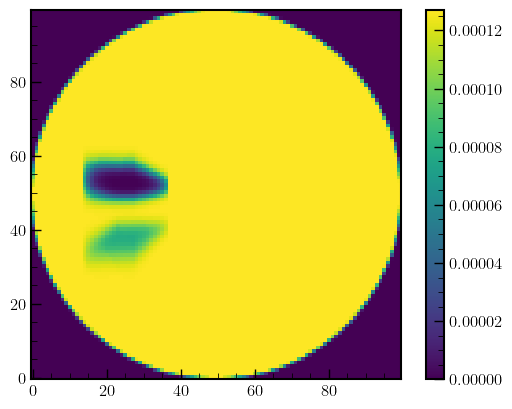

In [304]:
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(flux_map_oot * np.exp(-tau[:, : , -75]), origin='lower')
fig1.colorbar(im1, ax=ax1)

In [2]:
if True:
    print(1)

1
